In [15]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

import requests 
import pandas as pd
from bs4 import BeautifulSoup
import time

In [16]:
service = Service('C:\\Software\\chromedriver\\chromedriver.exe')
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=service, options=options)


driver.get("https://bet.hkjc.com/marksix/Results.aspx?lang=en")
time.sleep(10)

In [17]:
html2=driver.page_source
text_non2 = html2.replace("\n","")
bsObj2 = BeautifulSoup(text_non2, "html.parser")
histDrawResults=bsObj2.find_all("div", { "class" : "resultMainRow"} )
#histDrawResults

In [18]:
allHistDR = []
for hdr in histDrawResults:
    eachHistDR = {}
    drawId = ""
    for idx, hdrc in enumerate(hdr.children):
        if idx == 0:
            drawId = hdrc.find("a").get_text()
            eachHistDR["drawId"]=drawId[0:6]
        if idx == 1:
            drawDate = hdrc.get_text()    
            eachHistDR["drawDate"]=drawDate
        if idx == 3:
            #print(hdrc)
            eachDR = []
            for idxe, r in enumerate(hdrc.children):
                srce = r.find("img").get("src")
                noe=srce[srce.find("_")+1 : srce.find("_s.gif") ]
                if idxe == 6:
                    noe = "+"
                eachDR.append(noe)
            #eachHistDR["drawNumber"]=eachDR
            eachHistDR["1st"]=eachDR[0]
            eachHistDR["2nd"]=eachDR[1]
            eachHistDR["3rd"]=eachDR[2]
            eachHistDR["4th"]=eachDR[3]
            eachHistDR["5th"]=eachDR[4]
            eachHistDR["6th"]=eachDR[5]
            eachHistDR["SPNo"]=eachDR[7]
    allHistDR.append(eachHistDR)
#for i in allHistDR:
#    print(i)
df=pd.DataFrame.from_records(allHistDR)
df


,drawId,drawDate,1st,2nd,3rd,4th,5th,6th,SPNo
0,23/099,03/09/2023,15,20,25,39,45,48,28
1,23/098,31/08/2023,10,15,17,21,40,44,12
2,23/097,29/08/2023,03,06,07,33,36,46,04
3,23/096,26/08/2023,16,26,31,35,39,46,03
4,23/095,24/08/2023,06,18,29,31,44,46,08
5,23/094,22/08/2023,01,05,07,12,48,49,16
6,23/093,19/08/2023,08,14,18,20,23,25,44
7,23/092,17/08/2023,03,09,15,18,21,37,42
8,23/091,15/08/2023,04,12,17,37,38,39,41
9,23/090,12/08/2023,03,12,13,17,24,36,16


In [19]:
driver.quit()

In [20]:
from pymongo import MongoClient
from pymongo.errors import OperationFailure

In [21]:
url = 'mongodb://localhost:27017'
client = MongoClient(url)

try:
    db = client['mydb']
    collection = db['marksix']
    
    for index, row in df.iterrows():
        drawId=row['drawId']
        
        if collection.count_documents({'drawId' :drawId}) == 0:
            rec_id1 = collection.insert_one(row.to_dict())
            print(f"Draw ID : {drawId} Inserting...")
        #print(rec_id1)
        #print(row.to_dict())
    print("Import Ended\n")
    
    list_cur = list(collection.find().sort('drawId', -1))
    df_ms_hist = pd.DataFrame(list_cur)
    df_ms_hist = df_ms_hist[['drawId','drawDate', '1st', '2nd', '3rd', '4th', '5th', '6th', 'SPNo']]
    #print(df_ms_hist)

except OperationFailure as e:
    print(f"Error:\n {e}")
finally:
    client.close()

Import Ended



In [22]:
df_ms_hist

,drawId,drawDate,1st,2nd,3rd,4th,5th,6th,SPNo
0,23/099,03/09/2023,15,20,25,39,45,48,28
1,23/098,31/08/2023,10,15,17,21,40,44,12
2,23/097,29/08/2023,03,06,07,33,36,46,04
3,23/096,26/08/2023,16,26,31,35,39,46,03
4,23/095,24/08/2023,06,18,29,31,44,46,08
5,23/094,22/08/2023,01,05,07,12,48,49,16
6,23/093,19/08/2023,08,14,18,20,23,25,44
7,23/092,17/08/2023,03,09,15,18,21,37,42
8,23/091,15/08/2023,04,12,17,37,38,39,41
9,23/090,12/08/2023,03,12,13,17,24,36,16


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

Text(0, 0.5, 'Draw ID')

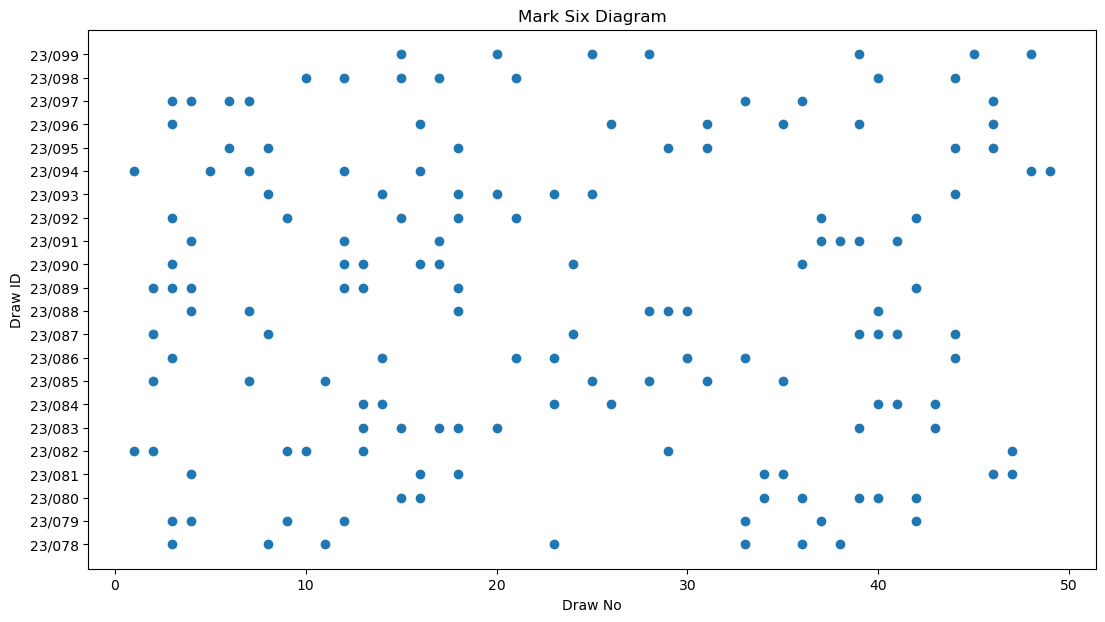

In [24]:
url = 'mongodb://localhost:27017'
client = MongoClient(url)

db = client['mydb']
collection = db['marksix']

list_cur = list(collection.find().limit(100).sort('drawId', 1))
df_ms_hist = pd.DataFrame(list_cur)
cols=list(df_ms_hist.columns)

L=[]
for index, row in df_ms_hist.iterrows():
    drawId=row[cols[1]]
    for i in range(7):
        D={}
        D['drawId']=drawId
        D['drawNo']=int(row[cols[i+3]])
        L.append(D)
df_ms_output=pd.DataFrame.from_records(L)

# create a figure and axis
#fig, ax = plt.subplots(figsize=(12,5))
fig, ax = plt.subplots(figsize=(13,7))

# scatter the sepal_length against the sepal_width
#ax.scatter(df_ms_output['drawId'], df_ms_output['drawNo'])
ax.scatter(df_ms_output['drawNo'], df_ms_output['drawId'])
# set a title and labels
ax.set_title('Mark Six Diagram')
ax.set_xlabel('Draw No')
ax.set_ylabel('Draw ID')

In [25]:
client.close()